In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import catboost as cb
import xgboost as xgb
import lightgbm as lgbm

from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, GradientBoostingClassifier, GradientBoostingRegressor, StackingClassifier, StackingRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Подготовка данных

In [26]:
pd.set_option('display.max_columns', 30)

In [27]:
data_class = pd.read_csv('../data/rainAUS_prepared.csv')
data_class

Date  MinTemp  MaxTemp  Rainfall  Evaporation  WindGustSpeed  \
0         12     13.4     22.9       0.6          4.0           44.0   
1         12      7.4     25.1       0.0          4.0           44.0   
2         12     12.9     25.7       0.0          4.0           46.0   
3         12      9.2     28.0       0.0          4.0           24.0   
4         12     17.5     32.3       1.0          4.0           41.0   
...      ...      ...      ...       ...          ...            ...   
142188     6      3.5     21.8       0.0          4.0           31.0   
142189     6      2.8     23.4       0.0          4.0           31.0   
142190     6      3.6     25.3       0.0          4.0           22.0   
142191     6      5.4     26.9       0.0          4.0           37.0   
142192     6      7.8     27.0       0.0          4.0           28.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
142188          15.0          13.0         59.0         27.0       1024.7   
142189          13.0          11.0         51.0         24.0       1024.6   
142190          13.0           9.0         56.0         21.0       1023.5   
142191           9.0           9.0         53.0         24.0       1021.0   
142192          13.0           7.0         51.0         24.0       1019.4   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  ord__Location  \
0            1007.1       8.0       7.0     16.9     21.8            2.0   
1            1007.8       7.0       7.0     17.2     24.3            2.0   
2            1008.7       7.0       2.0     21.0     23.2            2.0   
3            1012.8       7.0       7.0     18.1     26.5            2.0   
4            1006.0       7.0       8.0     17.8     29.7            2.0   
...             ...       ...       ...      ...      ...            ...   
142188       1021.2       7.0       7.0      9.4     20.9           41.0   
142189       1020.3       7.0       7.0     10.1     22.4           41.0   
142190       1019.1       7.0       7.0     10.9     24.5           41.0   
142191       1016.8       7.0       7.0     12.5     26.1           41.0   
142192       1016.5       3.0       2.0     15.1     26.0           41.0   

        ord__WindDir9am  ord__WindGustDir  ord__WindDir3pm  ord__RainToday  \
0                  13.0              13.0             14.0             0.0   
1                   6.0              14.0             15.0             0.0   
2                  13.0              15.0             15.0             0.0   
3                   9.0               4.0              0.0             0.0   
4                   1.0              13.0              7.0             0.0   
...                 ...               ...              ...             ...   
142188              2.0               0.0              0.0             0.0   
142189              9.0               0.0              1.0             0.0   
142190              9.0               6.0              3.0             0.0   
142191              9.0               3.0             14.0             0.0   
142192             10.0               9.0              3.0             0.0   

        RainTomorrow  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
142188             0  
142189             0  
142190             0  
142191             0  
142192             0  

[142193 rows x 22 columns]

In [28]:
data_reg_white = pd.read_csv('../data/winequality-white.csv', sep = ';')
data_reg_red = pd.read_csv('../data/winequality-red.csv', sep = ';')

In [29]:
data_reg_white['color'] = 0
data_reg_red['color'] = 1

In [30]:
data_reg = pd.concat([data_reg_white, data_reg_red], axis = 0)
data_reg.reset_index()
data_reg

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0             0.270         0.36            20.7      0.045   
1               6.3             0.300         0.34             1.6      0.049   
2               8.1             0.280         0.40             6.9      0.050   
3               7.2             0.230         0.32             8.5      0.058   
4               7.2             0.230         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
4                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  color  
0         8.8        6      0  
1         9.5        6      0  
2        10.1        6      0  
3         9.9        6      0  
4         9.9        6      0  
...       ...      ...    ...  
1594     10.5        5      1  
1595     11.2        6      1  
1596     11.0        6      1  
1597     10.2        5      1  
1598     11.0        6      1  

[6497 rows x 13 columns]

In [31]:
columns = [data_class.columns.to_list(), data_reg.columns.to_list()]

# Разделение выборок

In [32]:
y_cl = data_class['RainTomorrow'].to_numpy()
X_cl = data_class.drop(['RainTomorrow'], axis=1).to_numpy()

In [33]:
nm = NearMiss()
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, test_size=0.2)
X_train_cl, y_train_cl = nm.fit_resample(X_train_cl, y_train_cl.ravel())

In [34]:
y_reg = data_reg['quality'].to_numpy()
X_reg = data_reg.drop(['quality'], axis=1).to_numpy()
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, stratify = y_reg)

# Построение деревьев

In [35]:
def T(tr, task):
    if task == 'cl':
        fig = plt.figure(figsize=(25,20))
        k = tree.plot_tree(tr, feature_names=columns[0], class_names=['Rainy', 'NotRainy'], filled=True)
    elif task == 'rg':
        fig = plt.figure(figsize=(25,20))
        k = tree.plot_tree(tr, feature_names=columns[1], filled=True)

In [36]:
def show_class(y_test, predict):
    print(classification_report(y_test, predict))    

def show_roc(X_test, y_test, model):
    %matplotlib inline
    
    y_scores = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    
    fig = plt.figure(figsize=(6, 6))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print(f'AUC: {roc_auc_score(y_test, y_scores[:,1])}')

In [37]:
def show_reg(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    
    return {'MAE' : MAE, 'MSE' : MSE, 'MAPE': MAPE, 'R2' : R2}

## DecisionTreeClassifier

In [38]:
parameters_c = {
    'max_depth': np.arange(3, 5, 1), 'min_samples_split': np.arange(2, 10, 1), 
    'min_samples_leaf': np.arange(1, 5, 1), 'criterion': ['gini', 'entropy', 'log_loss']
}

clf = GridSearchCV(DecisionTreeClassifier(), parameters_c).fit(X_train_cl, y_train_cl)
print(clf.best_params_)
clf = clf.best_estimator_

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


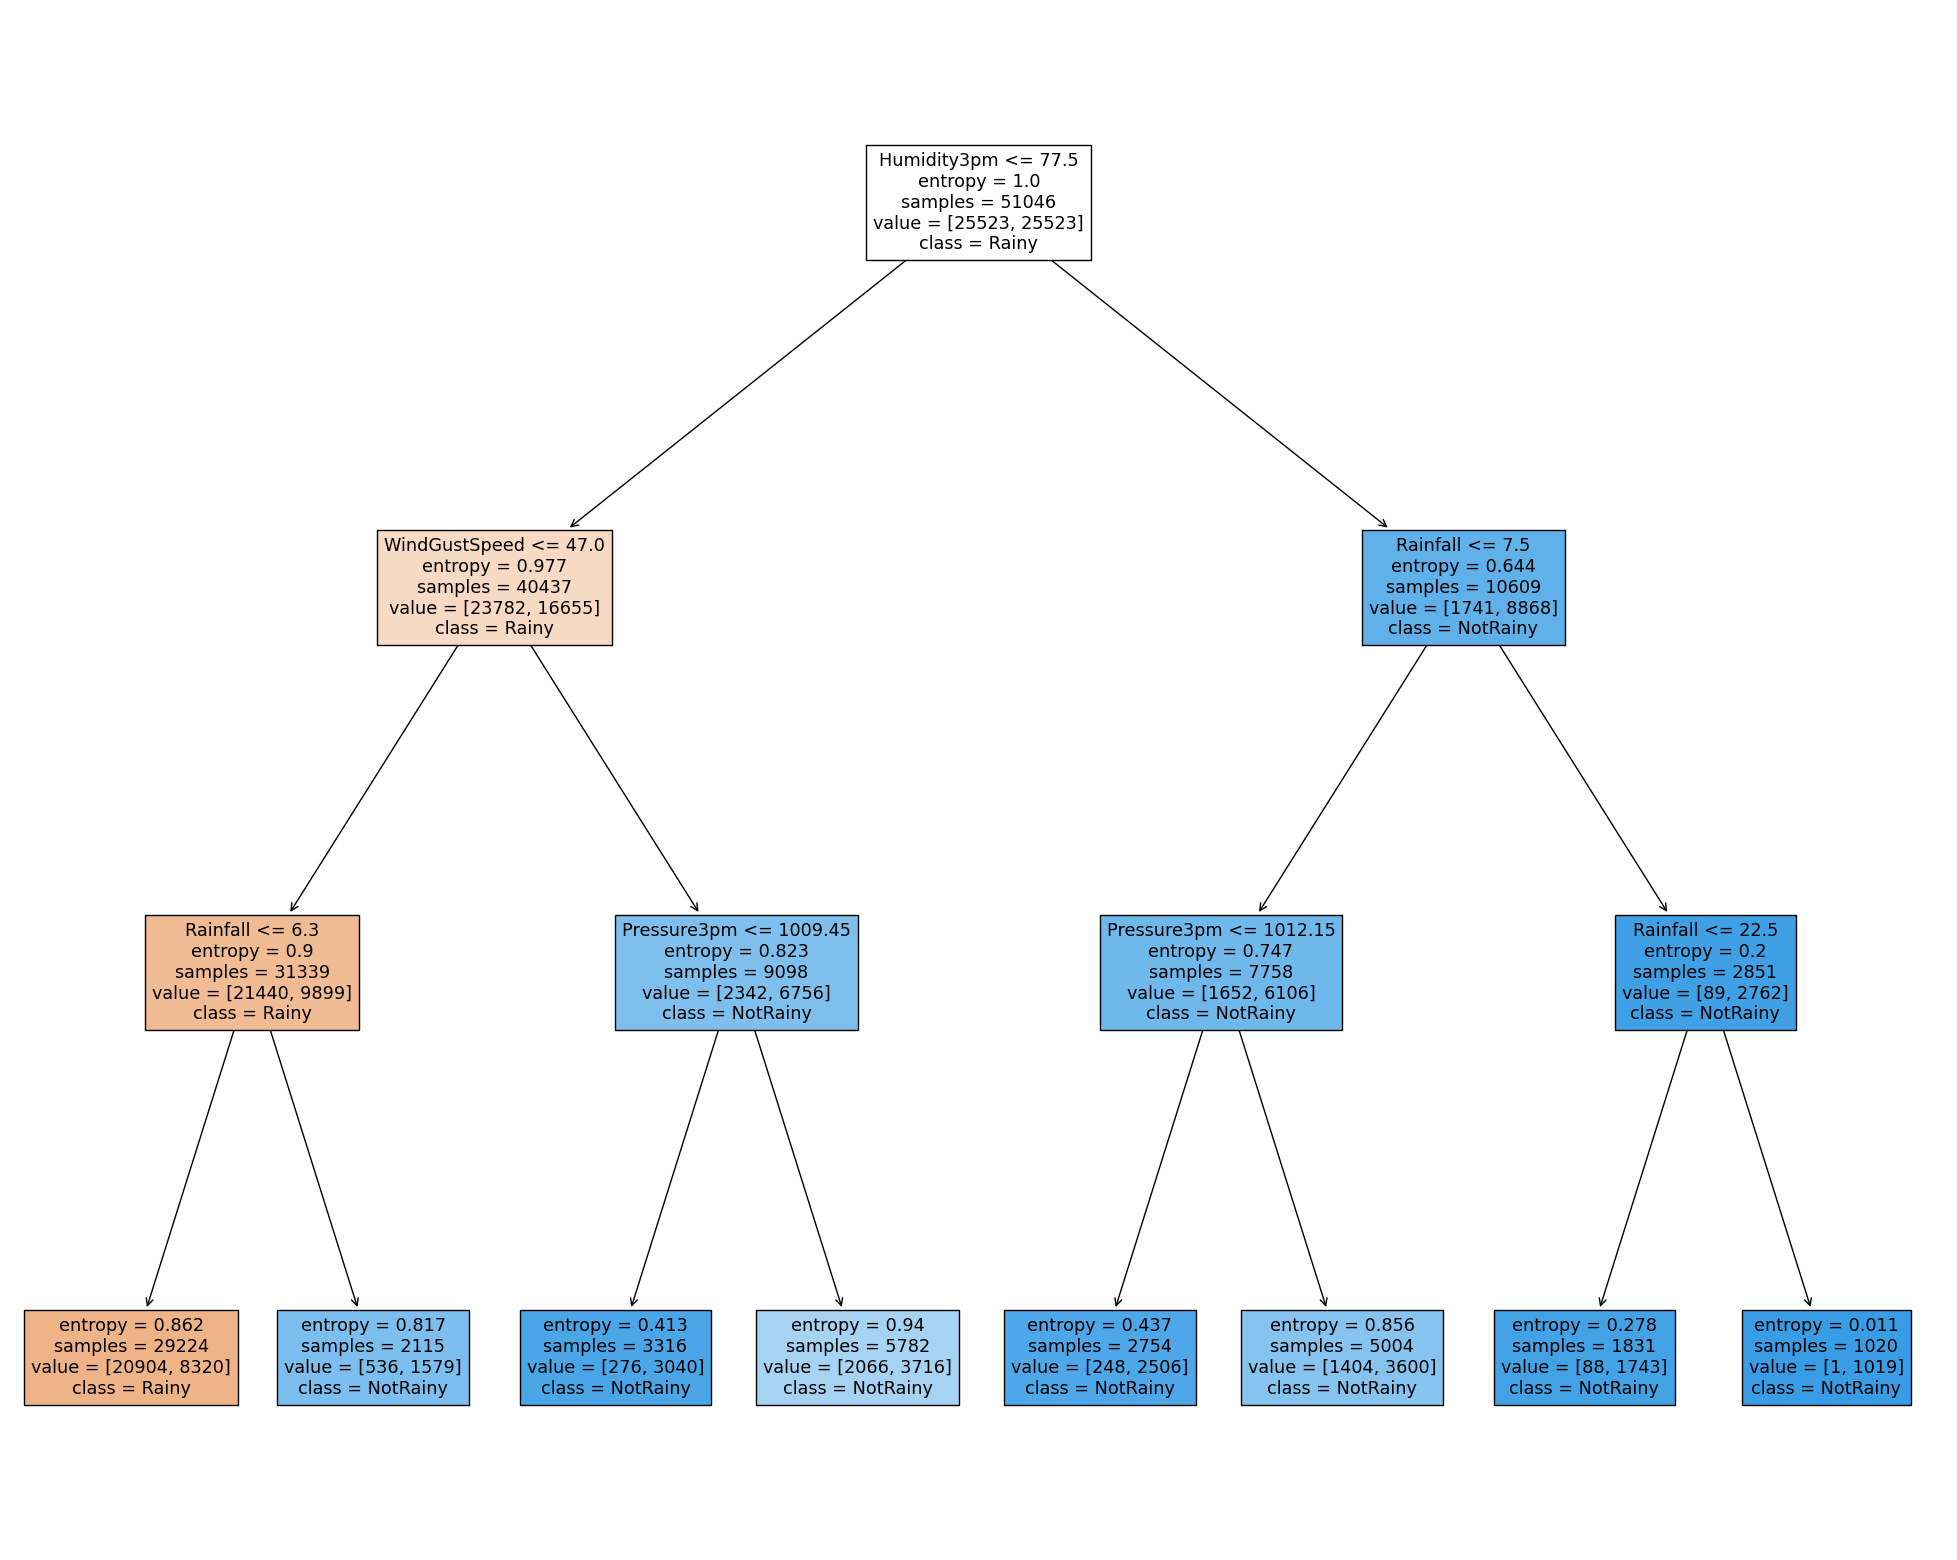

In [39]:
T(clf, 'cl')

In [40]:
y_pred = clf.predict(X_test_cl)

In [41]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81     22085
           1       0.42      0.67      0.52      6354

    accuracy                           0.72     28439
   macro avg       0.66      0.70      0.66     28439
weighted avg       0.78      0.72      0.74     28439



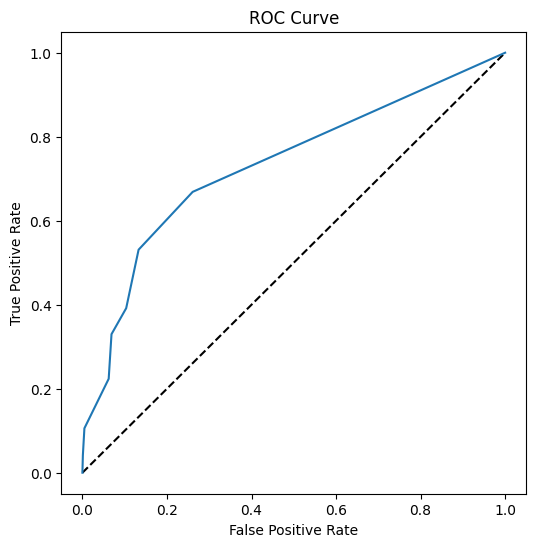

AUC: 0.7311302569571068


In [42]:
show_roc(X_test_cl, y_test_cl, clf)

## DecisionTreeRegressor

In [43]:
parameters_r = {
    'max_depth': np.arange(3, 5, 1), 'min_samples_split': np.arange(2, 10, 1), 
    'min_samples_leaf': np.arange(1, 5, 1), 'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}
reg = GridSearchCV(DecisionTreeRegressor(), parameters_r).fit(X_train_reg, y_train_reg)
print(reg.best_params_)
reg = reg.best_estimator_

{'criterion': 'poisson', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}


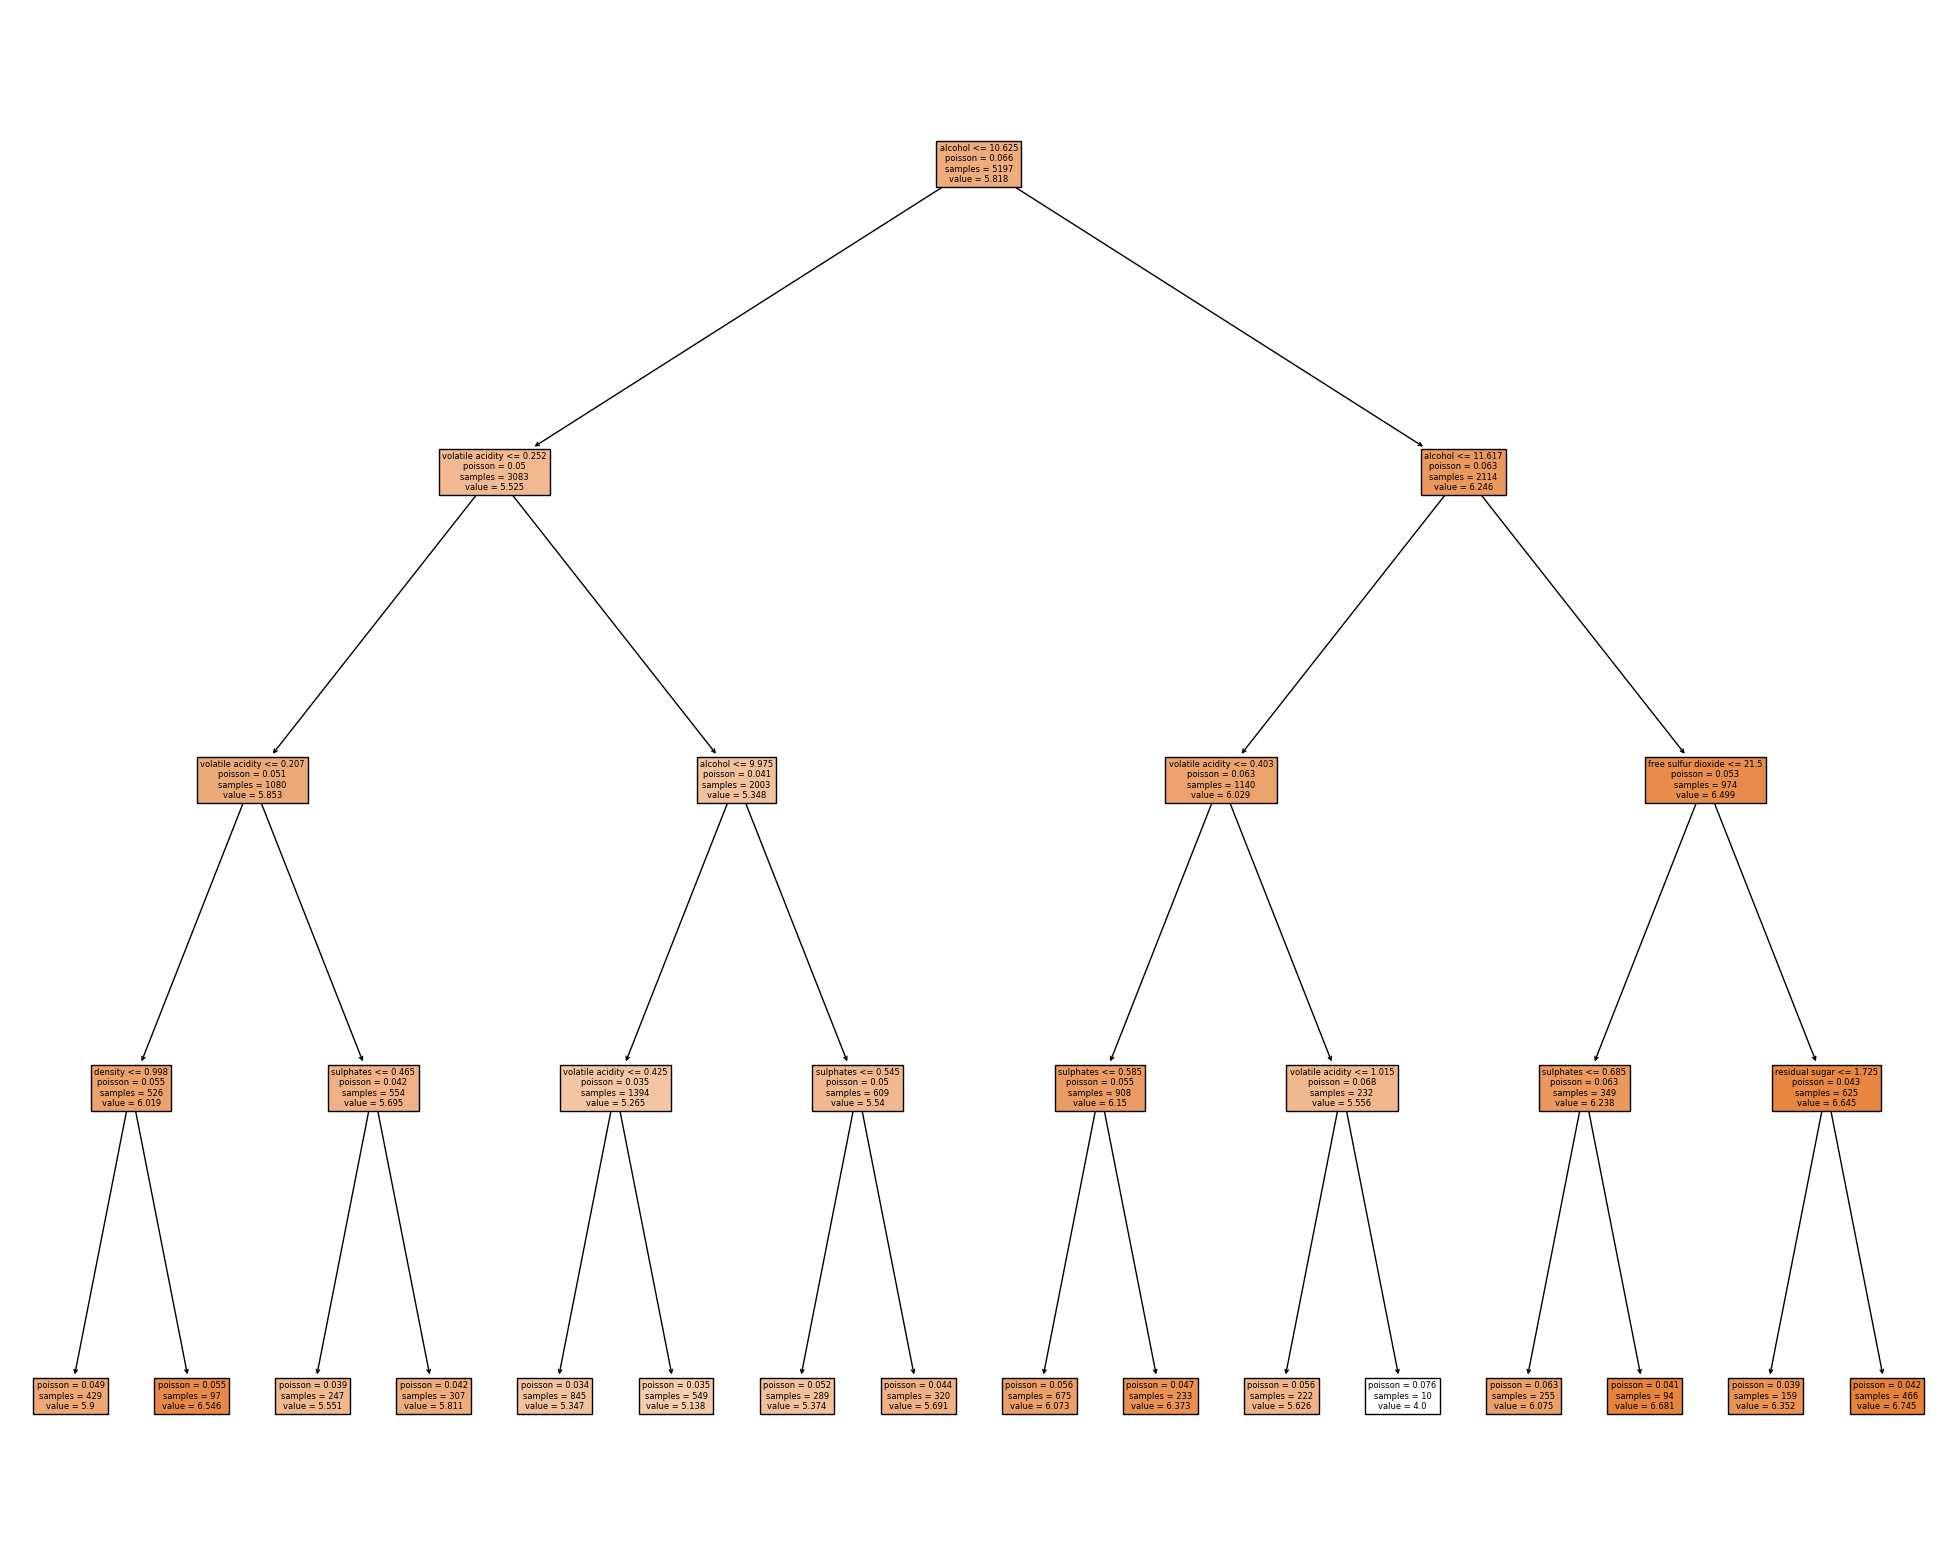

In [44]:
T(reg, 'rg')

In [45]:
y_pred = reg.predict(X_test_reg)

In [46]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.5753197044900088,
 'MSE': 0.5566932347899299,
 'MAPE': 0.10267483543252787,
 'R2': 0.270844148111851}

## Ансамбли

### BaggingClassifier

In [47]:
bclf = BaggingClassifier(estimator=DecisionTreeClassifier(criterion = 'gini', max_depth = 6), n_estimators=3, random_state=0).fit(X_train_cl, y_train_cl)

In [48]:
y_pred = bclf.predict(X_test_cl)

In [49]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.75      0.81     22085
           1       0.44      0.69      0.54      6354

    accuracy                           0.73     28439
   macro avg       0.67      0.72      0.68     28439
weighted avg       0.79      0.73      0.75     28439



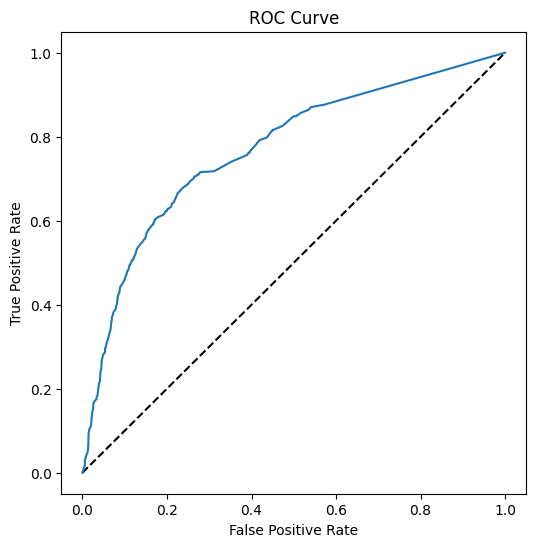

AUC: 0.768898240544712


In [50]:
show_roc(X_test_cl, y_test_cl, bclf)

## BaggingRegressor

In [51]:
breg = BaggingRegressor(estimator=DecisionTreeRegressor(criterion = 'poisson', max_depth = 6, min_samples_leaf = 4), n_estimators=3, random_state=0)
breg.fit(X_train_reg, y_train_reg)

BaggingRegressor(estimator=DecisionTreeRegressor(criterion='poisson',
                                                 max_depth=6,
                                                 min_samples_leaf=4),
                 n_estimators=3, random_state=0)

In [52]:
y_pred = breg.predict(X_test_reg)

In [53]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.5533628214528516,
 'MSE': 0.5132682503221904,
 'MAPE': 0.0989733142457723,
 'R2': 0.32772211889364544}

## GradientBoostingClassifier

In [54]:
parameters_gb = {'loss': ['log_loss', 'exponential'], 'learning_rate': np.arange(0, 1, 0.1)}

In [55]:
gbclf = GridSearchCV(GradientBoostingClassifier(), parameters_gb).fit(X_train_cl, y_train_cl)

In [56]:
y_pred = gbclf.predict(X_test_cl)

In [57]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.62      0.73     22085
           1       0.36      0.75      0.48      6354

    accuracy                           0.64     28439
   macro avg       0.63      0.68      0.61     28439
weighted avg       0.77      0.64      0.67     28439



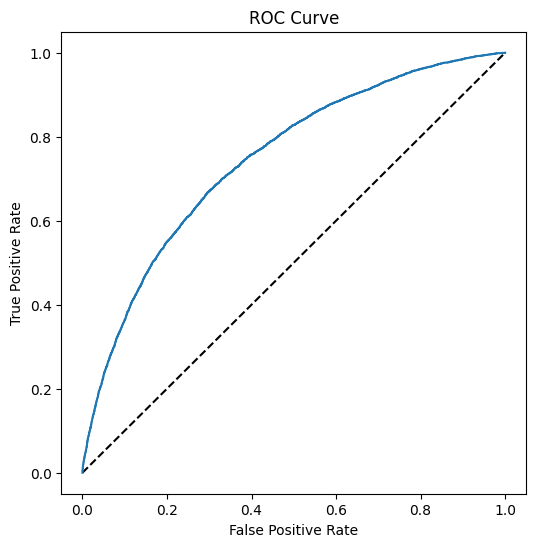

AUC: 0.7468494796729577


In [58]:
show_roc(X_test_cl, y_test_cl, gbclf)

## GradientBoostingRegressor

In [59]:
parameters_gb = {'n_estimators': np.arange(10, 150, 10)}

In [60]:
gbreg = GridSearchCV(GradientBoostingRegressor(), parameters_gb).fit(X_train_reg, y_train_reg)

In [61]:
y_pred = gbreg.predict(X_test_reg)

In [62]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.5309389739424761,
 'MSE': 0.4649355627957363,
 'MAPE': 0.09434331699456333,
 'R2': 0.3910281907928199}

## StackingClassifier

In [63]:
estimators = [
     ('lr', make_pipeline(StandardScaler(), LogisticRegression())),
     ('dt', DecisionTreeClassifier(criterion = 'gini', max_depth = 6)),
     ('knn', KNeighborsClassifier(n_neighbors = 13, weights = 'distance'))
]

sclf = StackingClassifier(estimators=estimators)

In [64]:
sclf.fit(X_train_cl, y_train_cl)
y_pred = sclf.predict(X_test_cl)

In [65]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.75      0.82     22085
           1       0.46      0.72      0.56      6354

    accuracy                           0.75     28439
   macro avg       0.68      0.74      0.69     28439
weighted avg       0.80      0.75      0.76     28439



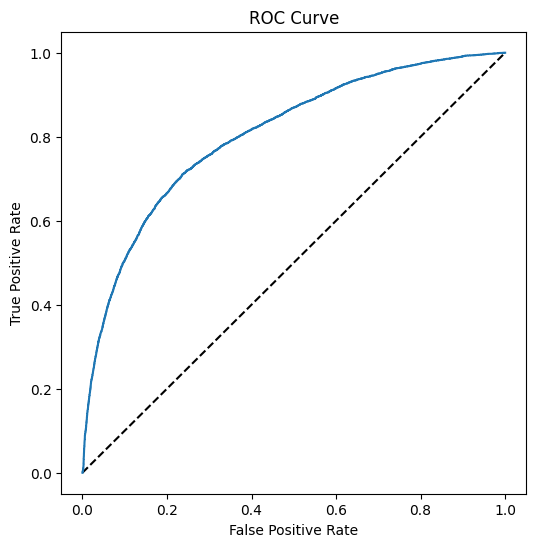

AUC: 0.804249876129576


In [66]:
show_roc(X_test_cl, y_test_cl, sclf)

## StackingRegressor

In [67]:
estimators = [
     ('elnet', make_pipeline(StandardScaler(), ElasticNet(alpha=0.01, l1_ratio=0.01))),
     ('dtr', DecisionTreeRegressor(criterion = 'poisson', max_depth = 6, min_samples_leaf = 4)),
]

sreg = StackingRegressor(estimators=estimators)

In [68]:
sreg.fit(X_train_reg, y_train_reg)
y_pred = sreg.predict(X_test_reg)

In [69]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.555752704348952,
 'MSE': 0.5169005788798405,
 'MAPE': 0.09918206840754518,
 'R2': 0.32296450112810793}

## Выбор наилучшей модели

### Classifier

Лучшим по всем метрикам (для второго класса) оказался stacking classifier с комбинацией из логистической регрессии, дерева классификации и kNN.

### Regressor

Лучшим оказался gradient boosting regressor, оторвавшийся по метрике R^2 далеко вперед относительно других ансамблей.

## Catboost

In [70]:
train_dataset_cl = cb.Pool(X_train_cl, y_train_cl)

In [71]:
train_dataset_reg = cb.Pool(X_train_reg, y_train_reg)

### Classifier

In [72]:
cbclf = cb.CatBoostClassifier(loss_function='Logloss',
                              eval_metric='Accuracy')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100, 150]}

cbclf.grid_search(grid, train_dataset_cl)

0:	learn: 0.7416495	test: 0.7450539	best: 0.7450539 (0)	total: 66.2ms	remaining: 3.25s
1:	learn: 0.7474777	test: 0.7526934	best: 0.7526934 (1)	total: 71.5ms	remaining: 1.71s
2:	learn: 0.7472328	test: 0.7526934	best: 0.7526934 (1)	total: 76.4ms	remaining: 1.2s
3:	learn: 0.7493633	test: 0.7546523	best: 0.7546523 (3)	total: 81.3ms	remaining: 935ms
4:	learn: 0.7512979	test: 0.7572968	best: 0.7572968 (4)	total: 86.1ms	remaining: 775ms
5:	learn: 0.7509550	test: 0.7569050	best: 0.7572968 (4)	total: 91.5ms	remaining: 671ms
6:	learn: 0.7508816	test: 0.7571009	best: 0.7572968 (4)	total: 96.8ms	remaining: 595ms
7:	learn: 0.7507836	test: 0.7568071	best: 0.7572968 (4)	total: 102ms	remaining: 538ms
8:	learn: 0.7547262	test: 0.7606268	best: 0.7606268 (8)	total: 109ms	remaining: 496ms
9:	learn: 0.7511999	test: 0.7572968	best: 0.7606268 (8)	total: 114ms	remaining: 457ms
10:	learn: 0.7551670	test: 0.7604310	best: 0.7606268 (8)	total: 121ms	remaining: 428ms
11:	learn: 0.7560486	test: 0.7624878	best: 0.76

{'params': {'depth': 10,
  'l2_leaf_reg': 3,
  'iterations': 150,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [73]:
y_pred = cbclf.predict(X_test_cl)
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.64      0.75     22085
           1       0.38      0.76      0.50      6354

    accuracy                           0.66     28439
   macro avg       0.64      0.70      0.62     28439
weighted avg       0.78      0.66      0.69     28439



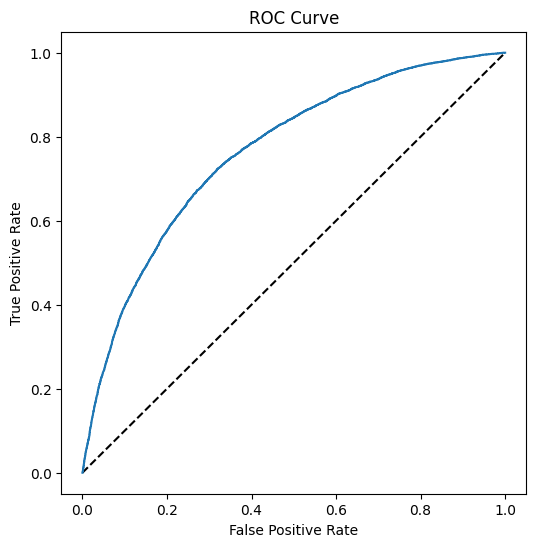

AUC: 0.7644006520718695


In [74]:
show_roc(X_test_cl, y_test_cl, cbclf)

### Regressor

In [75]:
cbreg = cb.CatBoostRegressor(loss_function='RMSE')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100, 150]}


cbreg.grid_search(grid, train_dataset_reg)

0:	learn: 5.7218981	test: 5.6652857	best: 5.6652857 (0)	total: 2.9ms	remaining: 142ms
1:	learn: 5.5544184	test: 5.4978560	best: 5.4978560 (1)	total: 3.86ms	remaining: 92.6ms
2:	learn: 5.3920867	test: 5.3354757	best: 5.3354757 (2)	total: 4.63ms	remaining: 72.6ms
3:	learn: 5.2347545	test: 5.1784960	best: 5.1784960 (3)	total: 5.42ms	remaining: 62.3ms
4:	learn: 5.0816782	test: 5.0260852	best: 5.0260852 (4)	total: 6.21ms	remaining: 55.9ms
5:	learn: 4.9338575	test: 4.8784464	best: 4.8784464 (5)	total: 6.97ms	remaining: 51.1ms
6:	learn: 4.7906445	test: 4.7354016	best: 4.7354016 (6)	total: 7.76ms	remaining: 47.7ms
7:	learn: 4.6516978	test: 4.5967264	best: 4.5967264 (7)	total: 8.61ms	remaining: 45.2ms
8:	learn: 4.5168161	test: 4.4620620	best: 4.4620620 (8)	total: 9.42ms	remaining: 42.9ms
9:	learn: 4.3862154	test: 4.3316405	best: 4.3316405 (9)	total: 10.2ms	remaining: 40.8ms
10:	learn: 4.2597929	test: 4.2056982	best: 4.2056982 (10)	total: 11ms	remaining: 39ms
11:	learn: 4.1373632	test: 4.0837592

{'params': {'depth': 10,
  'l2_leaf_reg': 1,
  'iterations': 150,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [76]:
y_pred = cbreg.predict(X_test_reg)
show_reg(y_test_reg, y_pred)

{'MAE': 0.47524767237816323,
 'MSE': 0.3943523299660896,
 'MAPE': 0.08510998614760365,
 'R2': 0.4834779890777614}

## XGBoost

### Classifier

In [77]:
params = {'max_depth': np.arange(3, 5, 1), 'learning_rate': np.arange(0, 1, 0.1), 'n_estimators': np.arange(50, 150, 25)}

In [78]:
xgclf = GridSearchCV(xgb.XGBClassifier(), params).fit(X_train_cl, y_train_cl)

In [79]:
y_pred = xgclf.predict(X_test_cl)

In [80]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.62      0.74     22085
           1       0.36      0.74      0.49      6354

    accuracy                           0.65     28439
   macro avg       0.63      0.68      0.61     28439
weighted avg       0.78      0.65      0.68     28439



### Regressor

In [81]:
xgreg = GridSearchCV(xgb.XGBRegressor(), params).fit(X_train_reg, y_train_reg)

In [82]:
y_pred = xgreg.predict(X_test_reg)

In [83]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.500639427625216,
 'MSE': 0.4366220946745145,
 'MAPE': 0.08935419804578298,
 'R2': 0.42811312317147165}

## LightGBM

### Classifier

In [84]:
lclf = GridSearchCV(lgbm.LGBMClassifier(), params).fit(X_train_cl, y_train_cl)

[LightGBM] [Info] Number of positive: 20418, number of negative: 20418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 40836, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 20419, number of negative: 20418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 40837, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500012 -> in

c:\users\ziabr\onedrive\рабочий стол\ml\myvenv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\ziabr\onedrive\рабочий стол\ml\myvenv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\ziabr\onedrive\рабочий стол\ml\myvenv\lib\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "c:\users\ziabr\onedrive\рабочий стол\ml\myvenv\lib\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = tra

In [85]:
y_pred = lclf.predict(X_test_cl)
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.63      0.74     22085
           1       0.36      0.75      0.49      6354

    accuracy                           0.65     28439
   macro avg       0.63      0.69      0.61     28439
weighted avg       0.78      0.65      0.68     28439



### Regressor

In [86]:
lreg = GridSearchCV(lgbm.LGBMRegressor(), params).fit(X_train_reg, y_train_reg)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 4157, number of used features: 12
[LightGBM] [Info] Start training from score 5.806351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\users\ziabr\onedrive\рабочий стол\ml\myvenv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\ziabr\onedrive\рабочий стол\ml\myvenv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\ziabr\onedrive\рабочий стол\ml\myvenv\lib\site-packages\lightgbm\sklearn.py", line 1049, in fit
    super().fit(
  File "c:\users\ziabr\onedrive\рабочий стол\ml\myvenv\lib\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = tra

In [87]:
y_pred = lreg.predict(X_test_reg)
show_reg(y_test_reg, y_pred)

{'MAE': 0.5005694632277823,
 'MSE': 0.4393189278417059,
 'MAPE': 0.0896304409911961,
 'R2': 0.42458081567690376}

## Выбор наилучшей модели

### Classifier

Лучшим оказался catboost, поскольку второй класс (означает, что на следующий день пойдет дождь) предсказывается с наибольшей точностью.

### Regressor

Лучшим оказался catboost, поскольку R^2 и MAPE метрики замтено лучше, чем у XGBoost и LightGBM.